## Housekeeping Settings

In [1]:
import numpy as np, pandas as pd, scanpy as sc, anndata as ad, matplotlib.pyplot as plt, os, pickle
import celloracle as co, subprocess, matplotlib.colors as mcolors

# visualization settings required to see plots in jupyter notebook
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300
# housekeeping settings to run the notebook
wd = '/ocean/projects/cis240075p/skeshari/igvf/bcell2/male_donor/'
out_path = os.path.join(wd, 'out_data', 'grn_inference')
os.makedirs(f"{out_path}/figures", exist_ok=True)
os.makedirs(f"{out_path}/out_files", exist_ok=True)
os.makedirs(f"{out_path}/scripts", exist_ok=True)
sc.settings.figdir = f"{out_path}/figures"

/ocean/projects/cis240075p/skeshari/.conda/envs/celloracle_env/lib/python3.8/site-packages/loompy/bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
/ocean/projects/cis240075p/skeshari/.conda/envs/celloracle_env/lib/python3.8/site-packages/loompy/bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for detai

## Reading the adata with scRNA and loading base GRN for ATAC part

In [2]:
path_to_adata = os.path.join(wd, 'out_data',f'sc_preproc/out_files/male_sc_processed.h5ad')
adata = sc.read_h5ad(path_to_adata)
n_cells_downsample = 30000 # Random downsampling into 30K cells if the anndata object include more than 30 K cells.
if adata.shape[0] > n_cells_downsample:
    sc.pp.subsample(adata, n_obs=n_cells_downsample, random_state=123) # Downsample into 30K cells
# CO uses the unscaled mRNA count for the Input of Oracle object.
adata.X = adata.layers["counts"].A.copy()
# Use only highly variable genes for the analysis
adata = adata[:, adata.var.highly_variable]
# Convert color names to hex codes
hex_codes = [mcolors.CSS4_COLORS[color] for color in adata.uns['leiden_colors']]
adata.uns['leiden_colors'] = hex_codes

In [4]:
# read MIRA data
mira_grn = pd.read_csv(f'{wd}/out_data/out_other_methods/ISD/ISD_matrix.chip.tsv', sep='\t', header=0, low_memory=False, index_col=0)
hvf_genes_mira = set(mira_grn.index)
mira_grn.columns = mira_grn.columns.str.split(r'[./]').str[0]
mira_grn = mira_grn.groupby(mira_grn.columns, axis=1).mean()
TFdatabase = pd.read_csv(f'{wd}/out_data/out_other_methods/human TF database.csv')
tfs = (set(mira_grn.columns).intersection(set(TFdatabase['HGNC symbol']))).union(['CD74'])
mira_grn = mira_grn[tfs]
threshold = np.percentile(mira_grn.values.flatten(), 95)
mira_grn = mira_grn.applymap(lambda x: 1 if x > threshold else 0)
print('Number of genes regulated by TFs:', mira_grn.T.sum(axis=1).mean(), 'on average from ISD matrix')
TF_to_TG_dictionary = {col: mira_grn.index[mira_grn[col] > 0].tolist() for col in mira_grn.columns}
# read CICERO data
cicero_GRN = pd.read_csv(os.path.join(wd, 'out_data', 'out_other_methods/base_GRN_dataframe.csv'))
cicero_GRN = cicero_GRN[cicero_GRN['gene_short_name'].isin(hvf_genes_mira)].drop(columns=['peak_id']).groupby('gene_short_name').count().sort_values(by='gene_short_name',ascending=False)
TF_to_TG_dictionary.update({col: cicero_GRN.index[cicero_GRN[col] != 0].tolist() for col in cicero_GRN.columns if col not in TF_to_TG_dictionary.keys()})
# save base GRN dictionary
with open(f'{out_path}/out_files/TF_to_TG_dictionary.pkl','wb') as f:
    pickle.dump(TF_to_TG_dictionary, f)

Number of genes regulated by TFs: 215.30011587485515 on average from ISD matrix


In [5]:
oracle = co.Oracle()
# assigning scRNA (adata) to oracle object
oracle.import_anndata_as_raw_count(adata=adata, cluster_column_name="leiden", embedding_name="X_umap")
# assigning scATAC (baseGRN) to oracle object
TG_to_TF_dictionary = co.utility.inverse_dictionary(TF_to_TG_dictionary)
oracle.addTFinfo_dictionary(TG_to_TF_dictionary)

4142 genes were found in the adata. Note that Celloracle is intended to use around 1000-3000 genes, so the behavior with this number of genes may differ from what is expected.


  0%|          | 0/3955 [00:00<?, ?it/s]

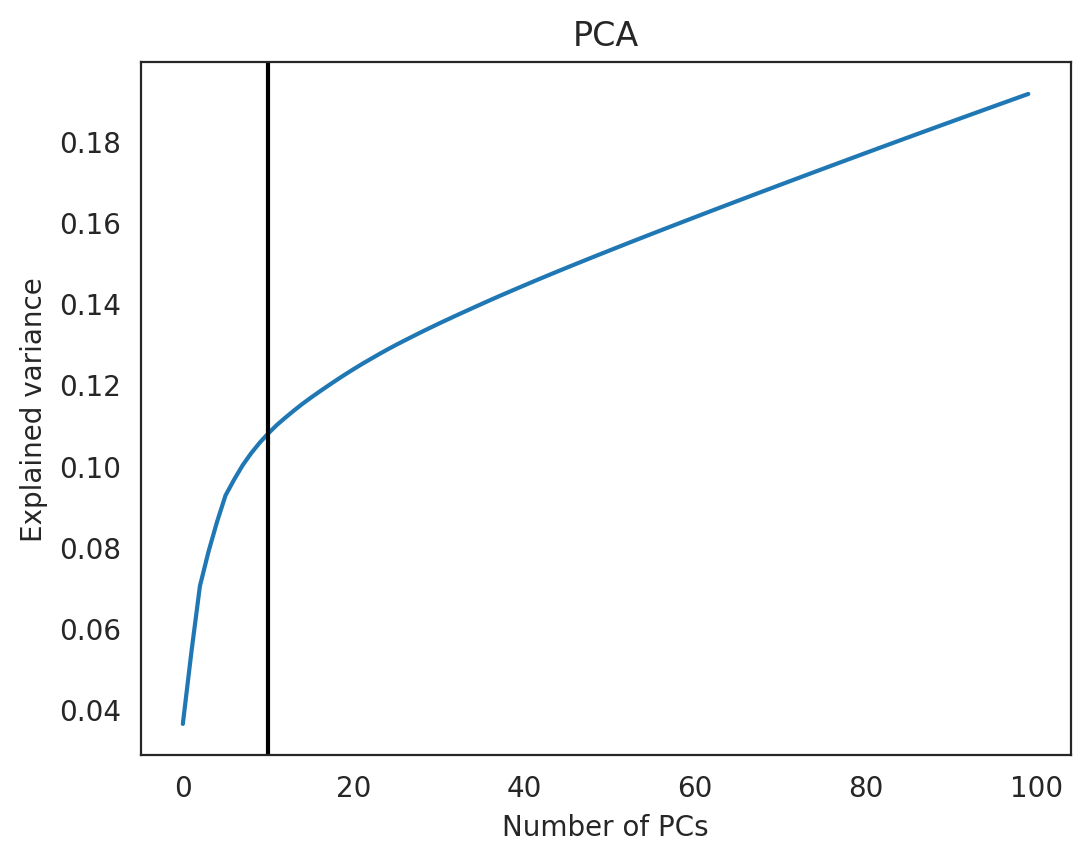

Optimal numbers of PCA dimensions are found to be : 10
Number of cell in the data are :30000
Auto-selected k is :750


In [6]:
# CellOracle uses the same strategy as velocyto for visualizing cell transitions. 
# This process requires KNN imputation in advance.
# For the KNN imputation, we first need to calculate and select PCs. 

# Perform PCA
oracle.perform_PCA()
# Select important PCs
plt.plot(np.cumsum(oracle.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k");plt.xlabel("Number of PCs");plt.ylabel("Explained variance");plt.title("PCA");plt.show()
print("Optimal numbers of PCA dimensions are found to be :",n_comps)
n_comps = min(n_comps, 50) # Ceiling the number of PCs to 50
# Performing KNN imputation
n_cell = oracle.adata.shape[0]
print(f"Number of cell in the data are :{n_cell}")
k = int(0.025*n_cell)
print(f"Auto-selected k is :{k}")
oracle.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8, b_maxl=k*4, n_jobs=-1)
# Save Oracle Object
oracle.to_hdf5(f'{out_path}/out_files/male_data.celloracle.oracle')

## GRN Construction takes time, consider running batch script. Following cell creates `.sh`, `.py` scripts and submits it. 

In [7]:
def shell_script_header_cpu(save_path, job_name, n_cpu=24):
    sbatch_script_header_cpu = f"""#!/bin/bash
#SBATCH --job-name="{job_name}"
#SBATCH --output="{save_path}/scripts/{job_name}.log"
#SBATCH -p EM
#SBATCH --ntasks-per-node=1
#SBATCH --cpus-per-task={n_cpu}
#SBATCH -t 0-9:30:00

module load anaconda3/2022.10
source activate celloracle_env

"""
    return sbatch_script_header_cpu

oracle_links_fitting_py_script = f"""
import celloracle as co, pandas as pd, numpy as np, os
wd = '{wd}'
out_path = os.path.join(f'{{wd}}', 'out_data', 'grn_inference')
oracle = co.load_hdf5(f'{{out_path}}/out_files/male_data.celloracle.oracle')
links = oracle.get_links(cluster_name_for_GRN_unit="leiden", alpha=10, verbose_level=10)
links.filter_links(p=0.001, weight="coef_abs", threshold_number=2000)
links.get_network_score()
links.merged_score.to_csv(f'{{out_path}}/out_files/bayesian_fitted_1_merged_network_scores.csv')
# links.to_hdf5(f'{{out_path}}/out_files/bayesian_fitted_1.celloracle.links')
# Calculate GRN for each population in clustering unit.
links.filter_links() # Getting back to default thresholds (p<0.001 and top 10k) for simulation of GRN -- so that we have enough edges to simulate the GRN
oracle.get_cluster_specific_TFdict_from_Links(links_object=links) #### Runs another round on links.filtered_links to get final links
oracle.fit_GRN_for_simulation(alpha=10, use_cluster_specific_TFdict=True)

# Save the final links for the KO simulation
links_after_fit = co.Links(name="links_after_fit")
links_after_fit.filtered_links = links.filtered_links #### Just for initialization
for cluster in links.filtered_links.keys():
    cluster_specific_links = oracle.coef_matrix_per_cluster[cluster].stack().reset_index()
    cluster_specific_links.columns = ['source', 'target', 'coef_mean']
    cluster_specific_links = cluster_specific_links[cluster_specific_links ['coef_mean'] != 0].reset_index(drop=True)
    cluster_specific_links['coef_abs'] = np.abs(cluster_specific_links['coef_mean'])
    cluster_specific_links.to_csv(f'{{out_path}}/out_files/cluster_{{cluster}}.csv', index=False)
    links_after_fit.filtered_links[cluster] = cluster_specific_links
links_after_fit.get_network_score()
links_after_fit.merged_score.to_csv(f'{{out_path}}/out_files/ridge_fitted_2_merged_network_scores.csv')
# Saving for KO simulation.
oracle.to_hdf5(f'{{out_path}}/out_files/oracle_fitted.celloracle.oracle')
"""

job_name = 'oracle_links_fitting'
# Create python script
with open(f'{out_path}/scripts/{job_name}.py', "w", encoding="utf-8") as f:
    f.write(oracle_links_fitting_py_script)
# Create bash script
with open(f'{out_path}/scripts/{job_name}.sh', "w", encoding="utf-8") as f:
    f.write(shell_script_header_cpu(save_path = out_path, job_name = job_name))
    f.write(f"python {out_path}/scripts/oracle_links_fitting.py \n")
    f.write(f"echo 'Oracle links fitting completed' \n")

subprocess.run(["sbatch", f'{out_path}/scripts/{job_name}.sh'])
print(f"Submitted {job_name}.sh")

Submitted batch job 30133640
Submitted oracle_links_fitting.sh
